    Grigoriou Stergios  9564                             grigster@ece.auth.gr
    Zacharioudaki Danai 9418 
Pattern Recognition 2023 Assignments A to C

In [17]:
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerTuple
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame as df


In [12]:
class my_Bayes_Model:
    #class for creating Bayes models using MLE on train data
    def __init__(self,dif_covmat=False):
        self.dif_covmat = dif_covmat#boolean determining if the model assumes different covariance matrix for each class or not (defaults to creating models with the same cov_matrix) 
        self.un_labels = []#unique labels of the model
        self.mu = []#mean values of each feature for each class label in un_labels
        self.covmat = []#list of covariance matrices of the feature vectors 
        self.aprior = []#apriori class probabilities
    def train(self,features,labels):
        #method for fitting the model to some data
        #features are the feature vectors columnwise (2D-np.array)
        #labels are the class labels corresponding to the features array
        self.un_labels = np.unique(labels)
        self.mu = [np.mean(features[labels==self.un_labels[i]],0) for i in range(len(self.un_labels))]
        self.aprior = [np.sum(y==self.un_labels[i])/len(y) for i in range(len(self.un_labels))]
        if self.dif_covmat:
        #calculating the covariance matrix of the feature vectors for each class
            self.covmat = [np.cov(features[labels==self.un_labels[i]],rowvar=False,bias=True) for i in range(len(self.un_labels))]
        else:
        #calculating the covariance matrix of the feature vectors
            self.covmat = np.cov(features,rowvar=False,bias=True)
    def predict(self,test_data):
        #method for predicting the labels of given data
        #test_data must have the same number of columns as the self.mu[i] vector
        if self.dif_covmat:
            invcov = [np.linalg.inv(self.covmat[i]) for i in range(len(self.covmat))]
            g = np.array([[-0.5*np.transpose(test_data[j]-self.mu[i])@invcov[i]@(test_data[j]-self.mu[i]) + np.log(self.aprior[i])\
                           for i in range(len(self.mu))] for j in range(len(test_data))])#calculating the value of each discriminant function
        else:
            invcov = np.linalg.inv(self.covmat)
            g = np.array([[-0.5*np.transpose(test_data[j]-self.mu[i])@invcov@(test_data[j]-self.mu[i]) + np.log(self.aprior[i])\
                           for i in range(len(self.mu))] for j in range(len(test_data))])#calculating the value of each discriminant function
        y_hat = self.un_labels[np.argmax(g,1)]#estimations (max disc value)
        return y_hat


def calc_regions(model,lowlim,uplim,resolution=100,plot_bool=False,ax=None):
    #this function calculates the predicted class regions of a 2 feature model. If plot_bool = True it also plots them using a pre-existing axis object. 
    # This function works with up to 8 classes.
    xs,ys = np.meshgrid(np.linspace(lowlim,uplim,resolution),np.linspace(lowlim,uplim,resolution))
    X_mesh = np.reshape(np.array([[[xs[i,j],ys[i,j]] for i in range(resolution)]for j in range(resolution)]),(resolution*resolution,2))#creating grid
    g = model.predict(X_mesh)#estimating g[i] on the whole grid for i=1,2,...,len(self.un_labels)
    regions = np.reshape(g,(resolution,resolution))#dividing the grid on the regions of each class
    num_of_classes = len(np.unique(regions))
    if plot_bool:
        colours = ['r','g','b','y','c','m','k','w']#This function works with up to 8 classes
        cmap = ListedColormap(colours[:num_of_classes])
        if ax is None:
            raise 'If you want to plot you must provide an axis object.'
        else:
            ax.contourf(xs,ys,regions,alpha=0.3,cmap=cmap)
    return xs,ys,regions


def plot_class_data(Xdata,labels,wrong,ax):
    #this fucntion (given a 2 column Xdata feature array, the corresponding class labels vector, the logical array of the wrong predictions and an axis object) plots 
    # the data with different coloyr for each true class and marks the wrong predicted points with triangles.
    colours = ['r','g','b','y','c','m','k','w']#This function works with up to 8 classes
    un_labels = np.unique(labels)
    correct = np.logical_not(wrong)
    pc = [ax.scatter(Xdata[np.logical_and(labels==un_labels[i],correct),1],Xdata[np.logical_and(y_test==un_labels[i],correct),0]
                     ,s=10,facecolors='none', edgecolors=colours[i]) for i in range(len(un_labels))]
    pw = [ax.scatter(Xdata[np.logical_and(labels==un_labels[i],wrong),1],Xdata[np.logical_and(y_test==un_labels[i],wrong),0],
                     marker='^',s=30,facecolors='none', edgecolors=colours[i]) for i in range(len(un_labels))]
    name = 'class '
    for i in range(len(un_labels)):
        name = name +('%d '% i)
    ax.legend([tuple(pc),tuple(pw)],[name,'error'], handler_map={tuple: HandlerTuple(ndivide=len(un_labels))})
    
    
def gridsearch(Xs, ys, cv=5, kernel='rbf', C=2.0 ** np.arange(start=-5, stop=17, step=2), gamma=None, degree=None, p=False):
    # Function for SVM hyperparameter tuning through cross validation
    grid_params = {}
    if hasattr(kernel, '__len__') and (not isinstance(kernel, str)):
        grid_params.update({'kernel': kernel})
    else:
        grid_params.update({'kernel': [kernel]})
    if hasattr(C, '__len__'):
        grid_params.update({'C': C})
    else:
        grid_params.update({'C': [C]})
    if hasattr(gamma, '__len__') and gamma is not None:
        grid_params.update({'gamma': gamma})
    elif gamma is not None:
        grid_params.update({'gamma': [gamma]})
    if hasattr(degree, '__len__') and degree is not None:
        grid_params.update({'degree': degree})
    elif degree is not None:
        grid_params.update({'degree': [degree]})
    if kernel == 'linear':
        del grid_params['kernel']
        cvSVM = GridSearchCV(svm.LinearSVC(dual='auto'), grid_params, scoring='accuracy', verbose=1, cv=cv, n_jobs=-1)
    else:
        cvSVM = GridSearchCV(svm.SVC(), grid_params, scoring='accuracy', verbose=1, cv=cv, n_jobs=-1)
    cvSVM.fit(Xs, ys)
    if p:
        bp = cvSVM.best_params_
        print(bp)
    return cvSVM
    

In [3]:
mypath = 'C:/Users/grist/Desktop/Pattern/'#You can change this variable to the directory of the folder that contains the dataset
data = np.loadtxt(os.path.join(mypath,'dataset.csv'), delimiter=',', dtype=np.float64)

In [13]:
X, X_test, y, y_test = train_test_split(data[:,0:2], data[:,2], test_size=0.5, random_state=73)#Spliting the datset into train and test data
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

Same Covariance Matrix: 0.3286 error.
Different Covariance Matrix: 0.2571 error.


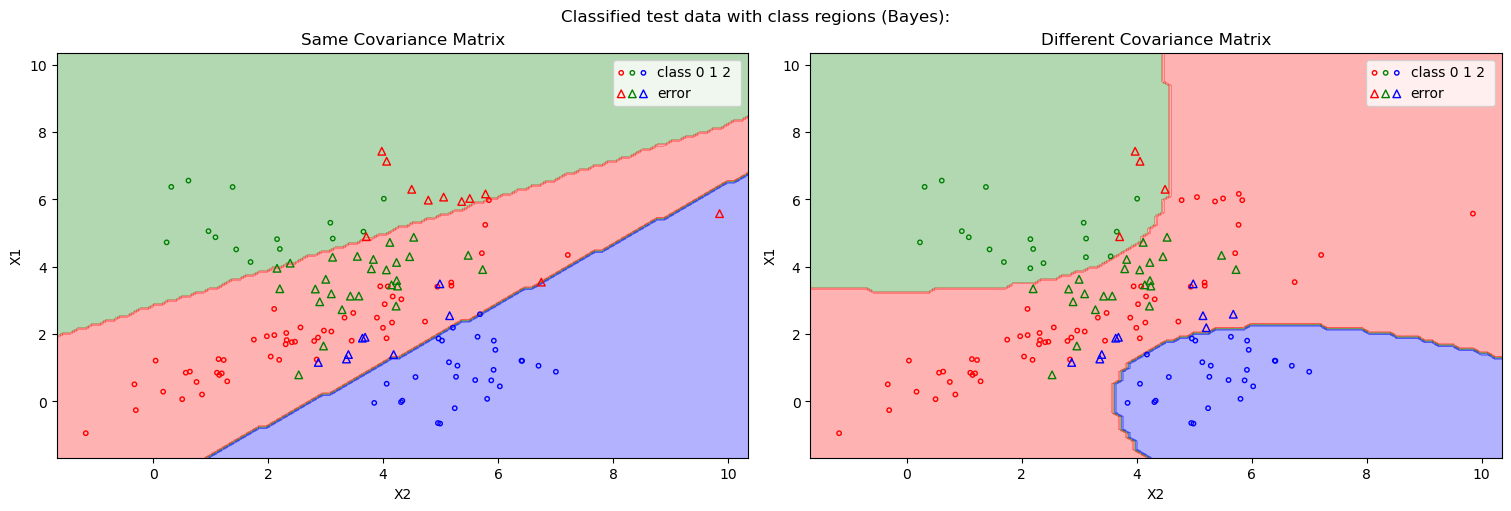

In [5]:
#A.1
#since it's the same to use Z-scores of data or the same data for the Bayes model we use the data
same = my_Bayes_Model()#initiating Bayes model object with same covariance matrix
same.train(X,y)#calculating mean values covariance matrix and apriori probabilities from the train data
y_same = same.predict(X_test)#using the stored values to predict the labels on the test data
wrong_class_same = y_same != y_test#logical vector of length len(y_test) with the positions of wrong estimations
error_same_S = np.sum(wrong_class_same)#the number of errors on the test set
#A.2
diff = my_Bayes_Model(True)#same with the A.1 with only difference that we assume different covariance matrix for each class
diff.train(X,y)
y_diff = diff.predict(X_test)
wrong_class_diff = y_diff != y_test
error_diff = np.sum(wrong_class_diff)
#A.3
#Plotting the test data using different colour for each true class. Plotting the estimated regions of each class. If an observation is missclasified is represented with the colour of the
#true class and a triangle instead of a circle.
fig, axes = plt.subplots(1,2,layout='constrained',figsize=(15,5))
titles = ('Same Covariance Matrix','Different Covariance Matrix')
models = (same,diff)
wrongs = (wrong_class_same,wrong_class_diff)
errors = (error_same_S,error_diff)
for n in range(len(models)):
    axes[n].set_xlabel('X2')
    axes[n].set_ylabel('X1')
    axes[n].set_title(titles[n])
    _,_,_ = calc_regions(models[n],np.min(X_test) - .5,np.max(X_test) +.5,plot_bool=True,ax=axes[n])
    plot_class_data(X_test,y_test,wrongs[n],axes[n])
    print(titles[n]+': %.4f error.'%(errors[n]/140))
fig.suptitle('Classified test data with class regions (Bayes):')
plt.show()

K = 1: 0.1500 error.
K = 2: 0.1714 error.
K = 3: 0.1500 error.
K = 4: 0.1714 error.
K = 5: 0.1643 error.
K = 6: 0.1571 error.
K = 7: 0.1500 error.
K = 8: 0.1500 error.
K = 9: 0.1357 error.
K = 10: 0.1571 error.


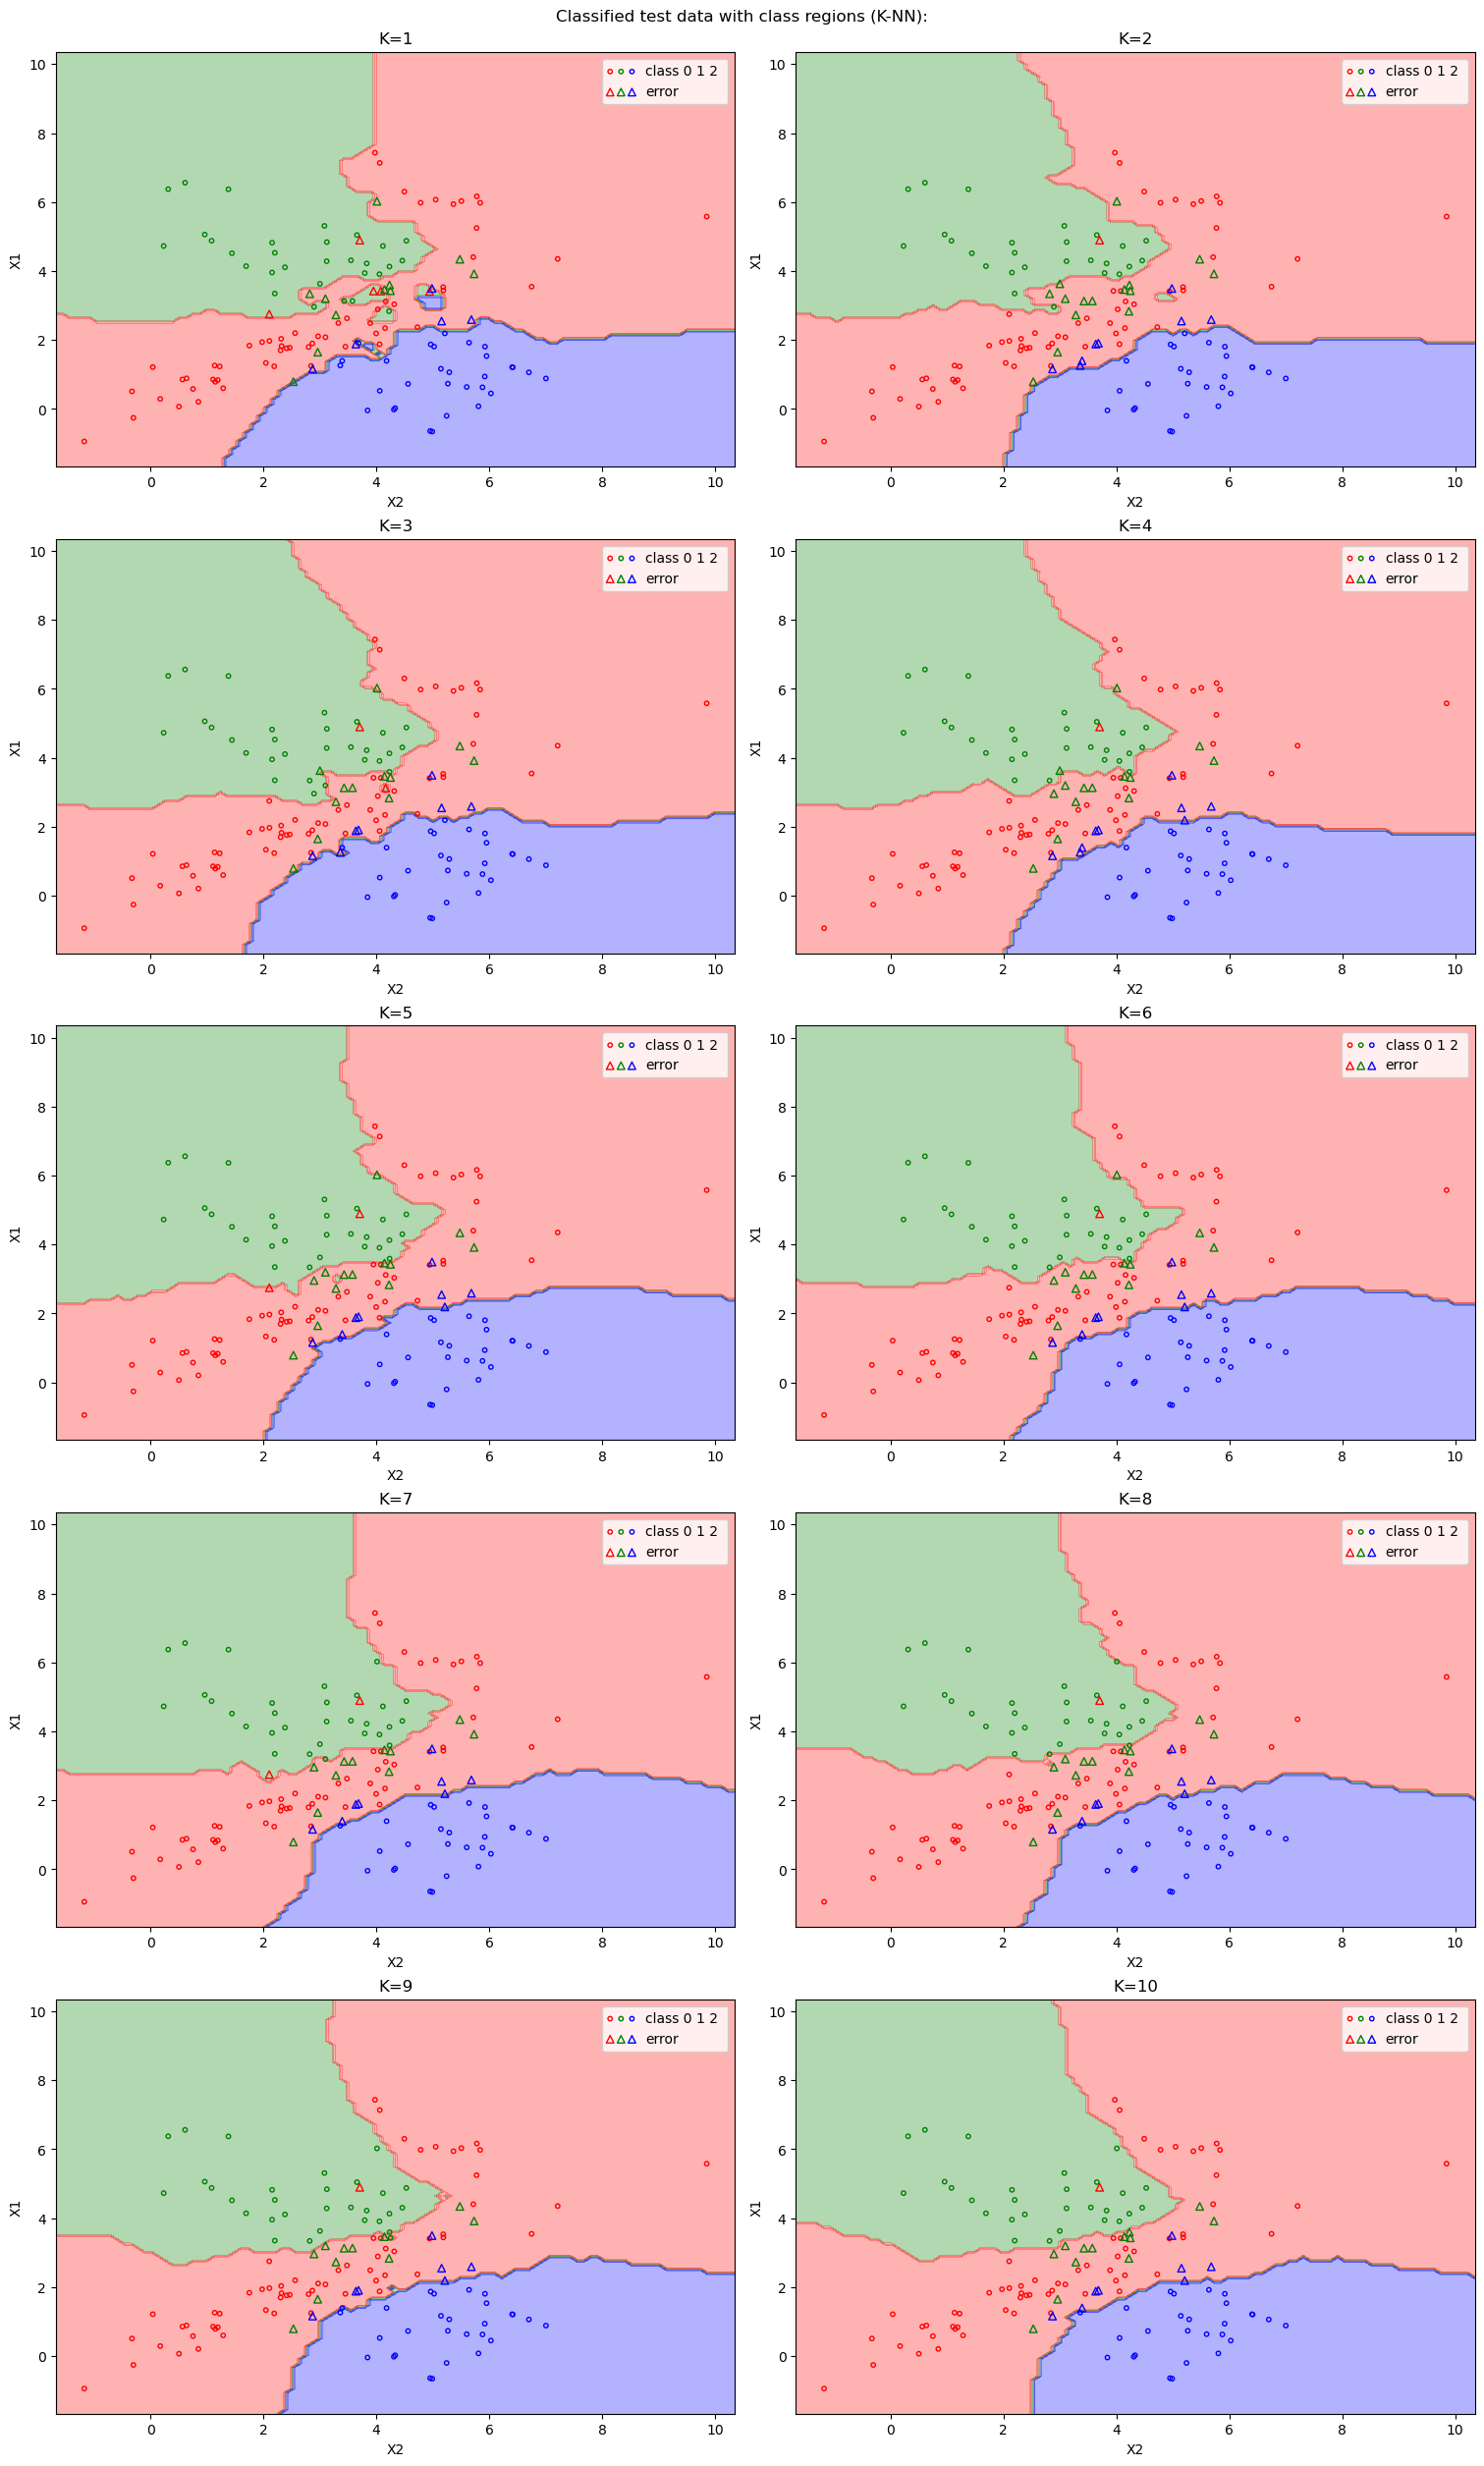

In [15]:
#B
fig, axes = plt.subplots(5,2,layout='constrained',figsize=(15,25))
error_knn = []
for n in range(5):
    for m in range(2):
        knnmodel = knn(n*2+m+1,algorithm='brute')
        knnmodel.fit(X,y)
        y_hat_knn = knnmodel.predict(X_test)
        wrong_knn= y_hat_knn != y_test
        error_knn.append(np.sum(wrong_knn))
        axes[n][m].set_xlabel('X2')
        axes[n][m].set_ylabel('X1')
        axes[n][m].set_title(('K=%d'%(n*2+m+1)))
        _,_,_ = calc_regions(knnmodel,np.min(X_test) - .5,np.max(X_test) +.5,plot_bool=True,ax=axes[n][m])
        plot_class_data(X_test,y_test,wrong_knn,axes[n][m])
        print('K = %d: %.4f error.'%(n*2+m+1,error_knn[n*2+m]/140))
fig.suptitle('Classified test data with class regions (K-NN):')
plt.show()

In [37]:
cvlinear = gridsearch(X,y,cv=5,kernel='linear', C=2.0**np.arange(start=-5,stop=17,step=0.1),p=True)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits
{'C': 294.0667788792314}


In [22]:
cv1_linear = df(cvlinear.cv_results_)
cv1_linear

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001197,0.000399,0.001199,4.014972e-04,0.03125,{'C': 0.03125},0.678571,0.892857,0.785714,0.785714,0.857143,0.800000,0.073540,220
1,0.001595,0.000489,0.000798,3.988992e-04,0.033493,{'C': 0.03349292070425915},0.714286,0.892857,0.785714,0.785714,0.857143,0.807143,0.062270,218
2,0.001795,0.000399,0.001197,3.988747e-04,0.035897,{'C': 0.035896823593657326},0.714286,0.892857,0.785714,0.785714,0.857143,0.807143,0.062270,218
3,0.001996,0.000634,0.000998,6.654228e-06,0.038473,{'C': 0.03847326291702861},0.750000,0.892857,0.785714,0.785714,0.857143,0.814286,0.052489,215
4,0.001796,0.000399,0.001396,4.885778e-04,0.041235,{'C': 0.0412346222116529},0.750000,0.892857,0.785714,0.785714,0.857143,0.814286,0.052489,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.001596,0.000798,0.001197,3.989461e-04,92681.900024,{'C': 92681.90002367814},0.785714,0.892857,0.821429,0.821429,0.892857,0.842857,0.042857,1
216,0.001396,0.000489,0.001396,4.887733e-04,99334.000903,{'C': 99334.00090282016},0.785714,0.892857,0.821429,0.821429,0.892857,0.842857,0.042857,1
217,0.001796,0.000399,0.000997,1.152329e-06,106463.546095,{'C': 106463.54609519895},0.785714,0.892857,0.821429,0.821429,0.892857,0.842857,0.042857,1
218,0.001197,0.000399,0.000997,8.920806e-07,114104.803432,{'C': 114104.80343234345},0.785714,0.892857,0.821429,0.821429,0.892857,0.842857,0.042857,1


In [25]:
cvrbf = gridsearch(X,y,cv=5,kernel='rbf', C=2.0**np.arange(start=-5,stop=17,step=0.5),gamma= 2.0**np.arange(start=-15,stop=5,step=0.1))

Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


In [32]:
cv_rbf = df(cvrbf.cv_results_)
cv_rbf


{'C': 2.8284271247461903, 'gamma': 0.07179364718731271, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002792,0.000399,0.001596,4.886167e-04,0.03125,0.000031,rbf,"{'C': 0.03125, 'gamma': 3.0517578125e-05, 'ker...",0.428571,0.392857,0.392857,0.392857,0.392857,0.400000,0.014286,7343
1,0.002383,0.000487,0.001795,3.988270e-04,0.03125,0.000033,rbf,"{'C': 0.03125, 'gamma': 3.270793037525308e-05,...",0.428571,0.392857,0.392857,0.392857,0.392857,0.400000,0.014286,7343
2,0.002792,0.000399,0.001595,4.883053e-04,0.03125,0.000035,rbf,"{'C': 0.03125, 'gamma': 3.505549179068098e-05,...",0.428571,0.392857,0.392857,0.392857,0.392857,0.400000,0.014286,7343
3,0.002393,0.000489,0.001796,3.987564e-04,0.03125,0.000038,rbf,"{'C': 0.03125, 'gamma': 3.757154581741075e-05,...",0.428571,0.392857,0.392857,0.392857,0.392857,0.400000,0.014286,7343
4,0.002792,0.000400,0.001196,3.988516e-04,0.03125,0.00004,rbf,"{'C': 0.03125, 'gamma': 4.026818575356729e-05,...",0.428571,0.392857,0.392857,0.392857,0.392857,0.400000,0.014286,7343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,0.003391,0.000489,0.001795,3.990174e-04,92681.900024,22.627417,rbf,"{'C': 92681.90002368316, 'gamma': 22.627416997...",0.571429,0.642857,0.678571,0.750000,0.714286,0.671429,0.061445,6654
8796,0.003492,0.000633,0.001995,6.308265e-04,92681.900024,24.251465,rbf,"{'C': 92681.90002368316, 'gamma': 24.251465064...",0.571429,0.607143,0.678571,0.750000,0.678571,0.657143,0.062270,6765
8797,0.003391,0.000488,0.001995,6.309019e-04,92681.900024,25.992077,rbf,"{'C': 92681.90002368316, 'gamma': 25.992076683...",0.571429,0.607143,0.678571,0.750000,0.642857,0.650000,0.061445,6811
8798,0.003687,0.000751,0.001995,1.507891e-07,92681.900024,27.857618,rbf,"{'C': 92681.90002368316, 'gamma': 27.857618025...",0.571429,0.535714,0.678571,0.750000,0.607143,0.628571,0.076931,6866


Linear SVM: 0.2214 error.


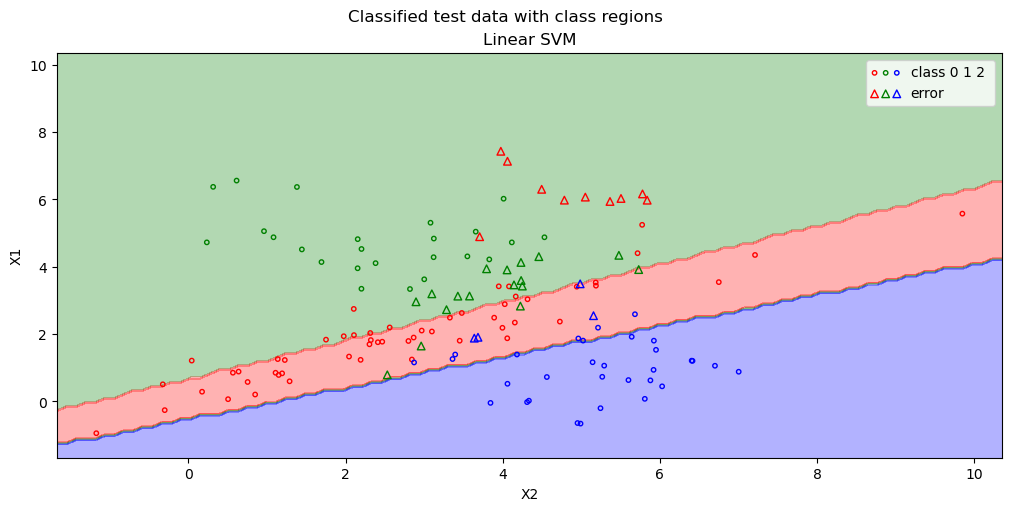

RBF SVM: 0.1357 error.


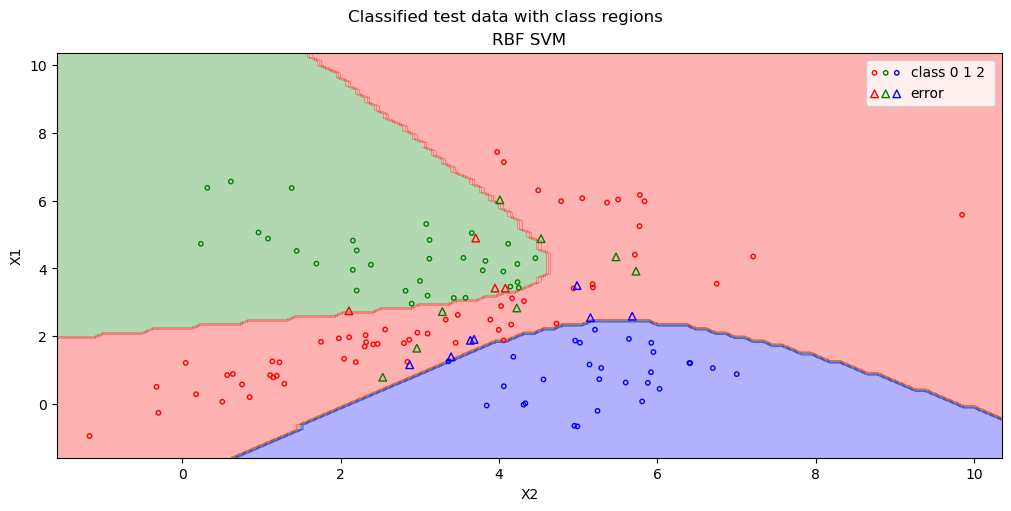

In [36]:
#C
linear = svm.LinearSVC(C=cvlinear.best_params_['C'],dual='auto')
linear.fit(X,y)
y_hat_linear = linear.predict(X_test)
wrong_linear= y_hat_linear != y_test
error_linear = np.sum(wrong_linear)
print('Linear SVM: %.4f error.'%(error_linear/140))
fig, axes = plt.subplots(1,1,layout='constrained',figsize=(10,5))
axes.set_xlabel('X2')
axes.set_ylabel('X1')
axes.set_title('Linear SVM')
_,_,_ = calc_regions(linear,np.min(X_test) - .5,np.max(X_test) +.5,plot_bool=True,ax=axes)
plot_class_data(X_test,y_test,wrong_linear,axes)
fig.suptitle('Classified test data with class regions')
plt.show()

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  
rbfSVM = GridSearchCV(svm.SVC(),param_grid, refit = True, verbose = 0)
rbfSVM.fit(X, y)
# params = cvrbf.best_params_
# print(params)
params = {'C': 8192.0, 'gamma': 0.011048543456039573, 'kernel': 'rbf'}
rbfsvm = svm.SVC(C=params['C'],gamma=params['gamma'],max_iter=10000)
rbfsvm.fit(X,y)
y_hat_rbf = rbfsvm.predict(X_test)
wrong_rbf = y_hat_rbf != y_test
error_rbf = np.sum(wrong_rbf)
print('RBF SVM: %.4f error.'%(error_rbf/140))
fig, axes = plt.subplots(1,1,layout='constrained',figsize=(10,5))
axes.set_xlabel('X2')
axes.set_ylabel('X1')
axes.set_title('RBF SVM')
_,_,_ = calc_regions(rbfsvm,np.min(X) - .5,np.max(X_test) +.5,plot_bool=True,ax=axes)
plot_class_data(X_test,y_test,wrong_rbf,axes)
fig.suptitle('Classified test data with class regions')
plt.show()

In [34]:
rbfsvm.support_vectors_

array([[1.9932, 3.8719],
       [2.8622, 3.8217],
       [2.7172, 5.2701],
       [3.5877, 5.0915],
       [2.7254, 5.2612],
       [1.7563, 3.7262],
       [3.6302, 4.5289],
       [1.9175, 4.1987],
       [7.5765, 5.    ],
       [6.6602, 3.7109],
       [3.4897, 3.5364],
       [2.8351, 3.2847],
       [3.0933, 2.9056],
       [3.8339, 4.9818],
       [4.2335, 4.3259],
       [3.2388, 3.7282],
       [5.0719, 4.1327],
       [2.6553, 4.0505],
       [3.44  , 4.9644],
       [7.5937, 2.9645],
       [2.9682, 2.8384],
       [3.0619, 2.9132],
       [1.2831, 3.6174],
       [1.9363, 4.568 ],
       [2.992 , 4.9971],
       [2.0229, 4.8182],
       [1.8683, 3.8231],
       [2.0939, 6.1706]])